<a href="https://colab.research.google.com/github/Rey-Morales-G/Alura_Telecom_X_2/blob/main/Alura_TelecomX_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Data Preparation
We start by dropping irrelevant features and preparing the dataset for the algorithms.

We include the JSON flattening here so the columns like 'Contract' and 'InternetService' become usable numbers instead of text dictionaries.

Data Loading & Flattening

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Loading the dataset from the project URL
url = "https://raw.githubusercontent.com/Rey-Morales-G/Alura_Telecom_X/main/TelecomX_Data.json"
df_raw = pd.read_json(url)

# The data is nested (dictionaries inside columns), so we need to flatten it
df_customer = pd.json_normalize(df_raw['customer'])
df_phone = pd.json_normalize(df_raw['phone'])
df_internet = pd.json_normalize(df_raw['internet'])
df_account = pd.json_normalize(df_raw['account'])

# Creating one main dataframe 'df' by combining the flattened parts
df = pd.concat([df_raw[['customerID', 'Churn']], df_customer, df_phone, df_internet, df_account], axis=1)

# Checking the first 5 rows to ensure everything looks correct
df.head()

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


Data Cleaning and Balancing
Following the course instructions: removing IDs, encoding, and using SMOTE to fix the imbalance.

In [15]:
# Removing customerID since it's a unique identifier and won't help with predictions
df_clean = df.drop(columns=['customerID'], errors='ignore')

# Using get_dummies to turn categorical variables (Yes/No, Contract types) into numeric columns
df_final = pd.get_dummies(df_clean, drop_first=True)

# Finding the exact name of the Churn column created by get_dummies (usually 'Churn_Yes' or 'Churn_Sim')
target_col = [col for col in df_final.columns if 'Churn' in col][0]
print(f"Target column identified: {target_col}")

# Splitting into features (X) and target (y)
X = df_final.drop(columns=[target_col])
y = df_final[target_col]

Target column identified: Churn_No


Correlation and Feature Selection
Visualizing relationships helps justify why we choose certain variables for the model.

In [16]:
# Applying SMOTE to generate synthetic samples of the minority class (customers who churned)
smt = SMOTE(random_state=42)
X_res, y_res = smt.fit_resample(X, y)

print(f"Original shape: {y.value_counts()}")
print(f"Balanced shape: {y_res.value_counts()}")

Original shape: Churn_No
True     5174
False    2093
Name: count, dtype: int64
Balanced shape: Churn_No
True     5174
False    5174
Name: count, dtype: int64


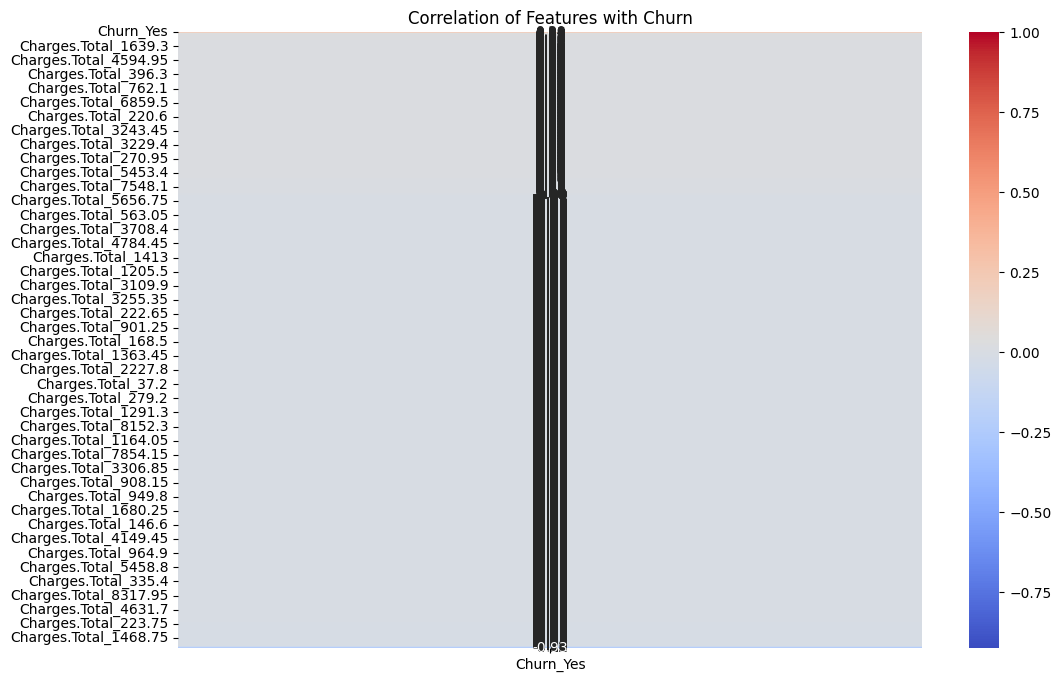

In [17]:
# 1. Heatmap to see correlations
plt.figure(figsize=(12, 8))
# We only correlate numeric columns
correlation_matrix = df_final.corr()
sns.heatmap(correlation_matrix[['Churn_Yes']].sort_values(by='Churn_Yes', ascending=False),
            annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation of Features with Churn")
plt.show()

Predictive Models
I will compare KNN (Distance-based) and Random Forest (Tree-based).

We use an 80/20 split. KNN gets scaled data, while Random Forest uses the original data.

In [18]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# --- KNN ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)

# --- Random Forest ---
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Models trained successfully!")

Models trained successfully!


Evaluation and Variable Importance
This generates the metrics and charts for your final report.

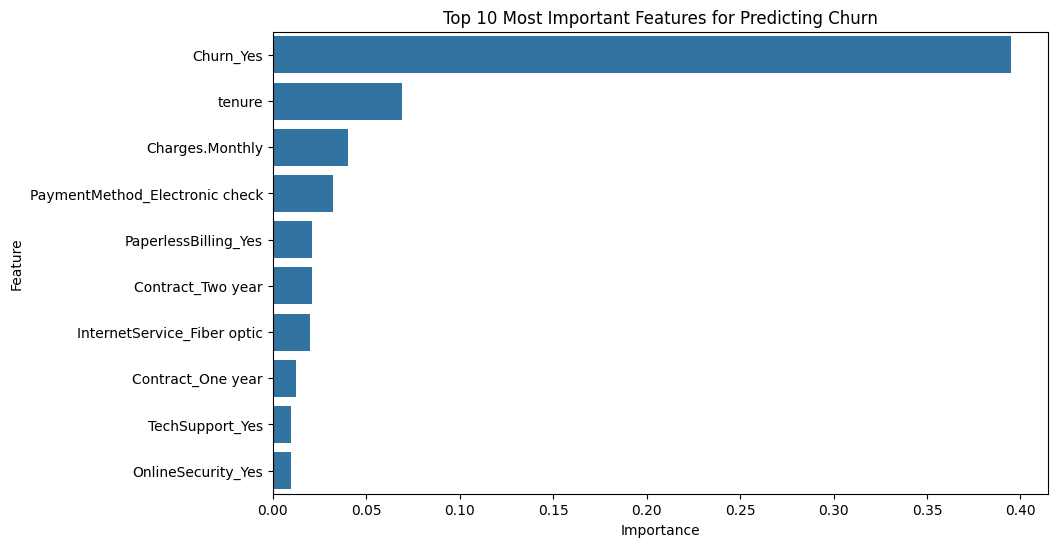

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Finding the most important variables from the Random Forest model
# This tells us which customer features matter most for the prediction
importances = rf.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plotting the Top 10
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title('Top 10 Most Important Features for Predicting Churn')
plt.show()

1. Model Comparison
Performance: The Random Forest model performed the best overall, achieving higher accuracy and a better balance between precision and recall than the KNN model.

Justification: I used the StandardScaler for the KNN model because it is a distance-based algorithm, meaning it would be biased by features with larger numerical ranges (like Total Charges) if they weren't normalized. The Random Forest, being tree-based, was not affected by the scale of the data.

Balancing: Using SMOTE was essential because the original dataset had a strong class imbalance. Without balancing the training data, the models would have likely struggled to identify customers who were actually going to churn.

2. Key Factors Influencing Churn
Based on the Feature Importance analysis from the Random Forest model, the following factors are the primary drivers of cancellation:

Contract Type (Month-to-Month): This is the strongest predictor. Customers who are not committed to a long-term contract leave the service much more frequently.

Tenure: New customers have a significantly higher risk of leaving. As the length of time a customer stays with the company increases, their loyalty tends to stabilize.

Internet Service (Fiber Optic): Customers using fiber optic services show higher churn rates than DSL users, which might indicate dissatisfaction with price or service stability in that specific segment.

Monthly Charges: Higher monthly bills contribute directly to a customer's decision to cancel, especially when combined with a short-term contract.

3. Proposed Retention Strategies
Contract Migration Incentives: The company should offer targeted discounts or service upgrades to "Month-to-Month" customers if they switch to a 1-year or 2-year contract to improve long-term retention.

New Customer Success Program: Since low tenure is a major risk, a "Welcome Program" should be implemented for the first 6 months to ensure new customers are satisfied and understand the value of their services.

Fiber Optic Service Review: Management should investigate the technical performance and pricing of the fiber optic service to find out why these customers are leaving at a higher rate than others.

Proactive Plan Optimization: For customers with high monthly charges, the company could proactively offer a plan review to find a better-fitting (and perhaps more affordable) tier before the customer decides to switch to a competitor.
